<a href="https://colab.research.google.com/github/geoskimoto/AWDB_SOAP_Request/blob/main/GetData_awdbSOAPcall_regressionINprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import xml.dom.minidom as minidom
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import datetime

def SOAP_Call(stationtriplets, elementCD, begindate, enddate):

  # Create a dictionaries to store the data
  headers = {'Content-type': 'text/soap'}
  # current_dictionary = {}
  
  # Define Web Service URL
  URL = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"

  # Define Parameters for SOAP Elements (getData:current and getCentralTendencyData:normals)
  SOAP_current = '''
  <?xml version="1.0" encoding="UTF-8"?>
  <SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:q0="http://www.wcc.nrcs.usda.gov/ns/awdbWebService" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
    <SOAP-ENV:Body>
      <q0:getData>
        <stationTriplets>STATIONTRIPLETS</stationTriplets>
        <elementCd>ELEMENTCD</elementCd>   
        <ordinal>1</ordinal>
        <duration>DAILY</duration>
        <getFlags>false</getFlags>
        <beginDate>BEGINDATE</beginDate>
        <endDate>ENDDATE</endDate>
        <alwaysReturnDailyFeb29>false</alwaysReturnDailyFeb29>   
      </q0:getData>
    </SOAP-ENV:Body>
  </SOAP-ENV:Envelope>

  '''.strip()
  #Read GetData documents - If <alwaysReturnDailyFeb29> is set to true, will set a null for every non leap year on the 29th,  
  #which breaks this request when selecting date ranges that include Feb 29.
  #other element codes: PREC, WTEQ (Water Equivalent/SWE)
  

  # Post SOAP Elements to AWDB Web Service and process results - getData
  SOAP_current = SOAP_current.replace("ELEMENTCD", elementCD)
  SOAP_current = SOAP_current.replace("STATIONTRIPLETS", stationtriplets)
  SOAP_current = SOAP_current.replace("BEGINDATE", begindate)
  SOAP_current = SOAP_current.replace("ENDDATE", enddate)

  response_current = requests.post(URL, data=SOAP_current, headers=headers)
  xmldoc = minidom.parseString(response_current.text)

  val_length = len(xmldoc.getElementsByTagName('values'))
  data = pd.DataFrame([xmldoc.getElementsByTagName('values')[i].firstChild.data for i in range(0,val_length)])

  date = datetime.datetime.strptime(begindate, "%m/%d/%Y").date()  #https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior; .date() after .strptime just tells it to make it a datetime object.  Def necessary.
  # print(date)
  Date = []                                                       
  for i in range(0, val_length): 
    date += datetime.timedelta(days=1)
    Date.append((date))

  # {str(xmldoc.getElementsByTagName('stationTriplet')[0].firstChild.data):{Date[j]:xmldoc.getElementsByTagName('values')[j].firstChild.data} for j in range(3)}

  data['Date'] = Date
  data.columns = [f'{elementCD}','Date']
  data.set_index('Date', inplace=True)
  
  data[f'{elementCD}'] = list(map(lambda x: float(x), data[f'{elementCD}']))
  
  return data
  # data.tail(7)

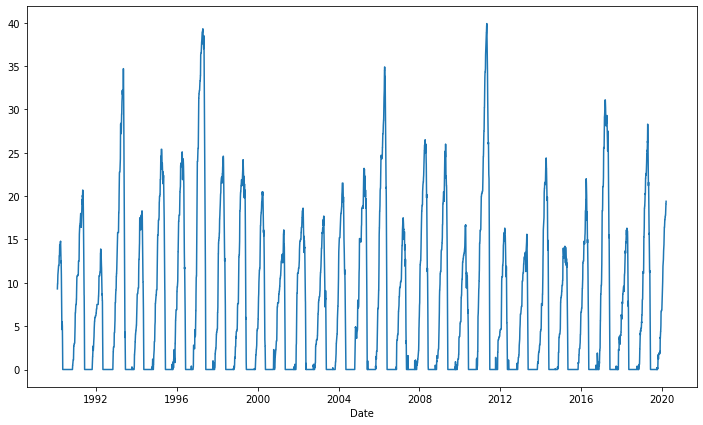

In [ ]:
#401:OR:SNTL
# %%timeit
df = SOAP_Call(stationtriplets='471:ID:SNTL',elementCD='WTEQ',begindate='02/01/1990',enddate='03/15/2020')
df['WTEQ'].plot(figsize=(12,7))

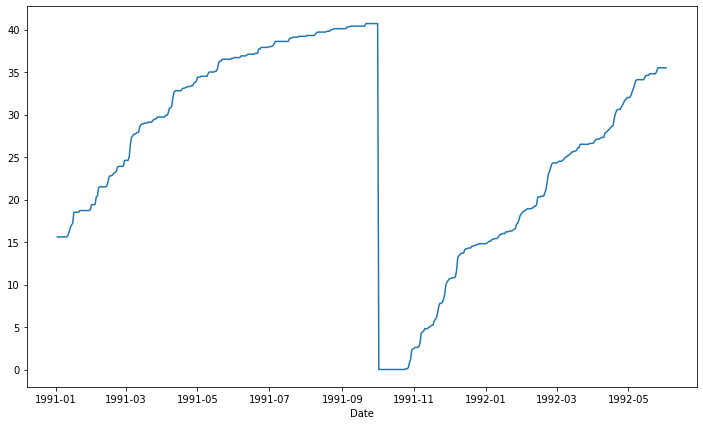

In [ ]:
df = SOAP_Call(stationtriplets='401:OR:SNTL',elementCD='PREC',begindate='01/01/1991',enddate='06/01/1992')
df['PREC'].plot(figsize=(12,7))

In [ ]:
df

,PREC
Date,
1991-01-02,15.6
1991-01-03,15.6
1991-01-04,15.6
1991-01-05,15.6
1991-01-06,15.6
...,...
1992-05-29,35.5
1992-05-30,35.5
1992-05-31,35.5


In [ ]:
stations = ['401:OR:SNTL', '471:ID:SNTL']

data = []
for i in stations:
  data.append(SOAP_Call(stationtriplets=i,elementCD='PREC',begindate='01/01/1991',enddate='06/01/1992'))

In [56]:
target = data[0]['PREC'].tolist() #['PREC']
features = data[1]['PREC'].tolist() 

indep_var_data = [target, features]
transposed_indep_var_data = np.array(indep_var_data).T.tolist()

In [70]:
from sklearn.linear_model import LassoCV, RidgeCV, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
# import statsmodels.api as sm
from functools import reduce




regr0 = RandomForestRegressor(n_estimators=100)

data = []
for i in stations:
  data.append(SOAP_Call(stationtriplets=i,elementCD=parameter_of_interest,begindate=begindate,enddate=enddate))

target = data[0]['PREC']
features = np.array(data[1]['PREC']).reshape(-1, 1)

# target = transposed_indep_var_data[0]
# features = transposed_indep_var_data[1]

regr0.fit(features, target)
# regr0.fit(features.T.tolist(),target.T.tolist())


y_pred = regr0.predict(features)
# # y_pred2 = pd.DataFrame(y_pred, columns=['y_pred'])
# # y_pred2['Date'] = site_list.index
# # y_pred2.set_index('Date', inplace=True)

# # site_list['y_pred'] = y_pred2
# # abs_error = abs(y_pred - target)
# # abs_error = pd.DataFrame(abs_error)
# # abs_error['Date'] = site_list.index
# # abs_error.set_index('Date',inplace=True)
# # site_list['abs_error'] = abs_error
# # site_list_sorted = site_list.sort_values('abs_error',ascending=False)

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Predictions vs. Actual','Regression Plot')) 
    # specs=[[{}, {}],
    #      [{"colspan": 2}, None]])
# # fig = go.Figure()

# 'Predictions vs. Actual'
fig.add_trace(go.Scatter(
    y = target,
    x = target.index,
    mode = 'lines',
    # name = f'{site_list.columns[0]}'
), 
row=1, col=1)

fig.add_trace(go.Scatter(
    y = y_pred,
    x = target.index,
    mode = 'lines',
    name = 'model predictions'
), 
row=1, col=1)

# # Regression Plot
fig.add_trace(go.Scatter(
  x=data[1]['PREC'],
  y=target,
  mode='markers',
  # hovertext = site_list.index,
  marker=dict(size=5, line=dict(width=1.2))   
), 
row=2, col=1
)

fig.add_trace(go.Scatter(
  x=data[1]['PREC'],
  y=y_pred,
  mode='lines',
  hovertext = y_pred,  
), 
row=2, col=1)

fig.update_xaxes(title_text = f"{parameter_of_interest}", row=1, col=1)
fig.update_yaxes(title_text = 'Date', row=1, col=1) 

# fig.update_xaxes(title_text = f"{site_list.columns[0]}", row=2, col=1)
# fig.update_yaxes(title_text = f'{site_list.columns[1:len(stations)', row=2, col=1) 

fig.update_layout(
    showlegend=False,
    height=1550,
    width=1150 
)
fig.show()

In [ ]:
stations = ['401:OR:SNTL', '471:ID:SNTL']
parameter_of_interest = 'PREC'
begindate='01/01/1991'
enddate='06/01/1992'


multipleRegression_fitData(stations, parameter_of_interest, begindate = begindate, enddate=enddate, regression_model='Random Forest')

ValueError: ignored

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV, HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error


def multipleRegression(stations, parameter_of_interest, regression_model):
  # global df, df_merged, site_list, features, target, regr0, regr1, abs_error, site_list_sorted, y_pred #for troubleshooting
  global regr0
#RidgeCV and LassoCV have built-in cross-validation to figure out the best alpha/regularizer value. Regularizer not super useful without a test set.
  if regression_model == 'Lasso':
    regr0 = LassoCV(alphas=(0.001,0.01,0.1,1,10,100,1000))
  elif regression_model == 'Ridge':
    regr0 = RidgeCV(alphas=(0.001,0.01,0.1,1,10,100,1000))
  elif regression_model == 'SVM':
    regr0 = svm.SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
  elif regression_model == 'Huber':
    regr0 = HuberRegressor()
  elif regression_model == 'GradientBoost':
    regr0 = GradientBoostingRegressor(random_state=0, n_estimators=100)
  elif regression_model == 'AdaBoost':
    regr0 = AdaBoostRegressor(random_state=0, n_estimators=100)
  elif regression_model == 'Random Forest':
    regr0 = RandomForestRegressor(n_estimators=100)
  else:
    print('Choose either Lasso, Ridge, SVM, Huber, GradientBoost, AdaBoost, or Random Forest')
  # df.iloc[:, df.columns.get_level_values(1)=='A']
  site_list = ORWA_Sites2[stations].xs(f'{parameter_of_interest}', axis=1, level='parameter',drop_level=False).dropna()

  target = site_list.iloc[:,0]
  features = site_list.iloc[:,1:]

  regr0.fit(features,target) 

  y_pred = regr0.predict(features)
  y_pred2 = pd.DataFrame(y_pred, columns=['y_pred'])
  y_pred2['Date'] = site_list.index
  y_pred2.set_index('Date', inplace=True)
  
  site_list['y_pred'] = y_pred2
  abs_error = abs(y_pred - target)
  abs_error = pd.DataFrame(abs_error)
  abs_error['Date'] = site_list.index
  abs_error.set_index('Date',inplace=True)
  site_list['abs_error'] = abs_error
  site_list_sorted = site_list.sort_values('abs_error',ascending=False)

  fig = make_subplots(
      rows=2, cols=1,
      subplot_titles=('Predictions vs. Actual','Regression Plot')) 
      # specs=[[{}, {}],
      #      [{"colspan": 2}, None]])
  # # fig = go.Figure()

# 'Predictions vs. Actual'
  fig.add_trace(go.Scatter(
      y = target,
      x = site_list.index,
      mode = 'lines',
      name = f'{site_list.columns[0]}'
  ), 
  row=1, col=1)

  fig.add_trace(go.Scatter(
      y = site_list['y_pred'],
      x = site_list.index,
      mode = 'lines',
      name = 'model predictions'
  ), 
  row=1, col=1)

# Regression Plot
  fig.add_trace(go.Scatter(
    x=site_list.iloc[:,1],
    y=target,
    mode='markers',
    hovertext = site_list.index,
    marker=dict(size=5, line=dict(width=1.2))   
  ), 
  row=2, col=1
  )

  fig.add_trace(go.Scatter(
    x=site_list.iloc[:,1],
    y=y_pred,
    mode='lines',
    hovertext = y_pred,  
  ), 
  row=2, col=1)

  fig.update_xaxes(title_text = f"{parameter_of_interest}", row=1, col=1)
  fig.update_yaxes(title_text = 'Date', row=1, col=1) 

  # fig.update_xaxes(title_text = f"{site_list.columns[0]}", row=2, col=1)
  # fig.update_yaxes(title_text = f'{site_list.columns[1:len(stations)', row=2, col=1) 

  fig.update_layout(
      showlegend=False,
      height=1550,
      width=1150 
  )
  fig.show()

  # r_sq = regr0.score(target, y0)
  # print('coefficient of determination:', r_sq)
  # print('slope:', regr0.coef_)
  # print('intercept:', regr0.intercept_)
  print('RMSE', mean_squared_error(target, y_pred))

  return site_list_sorted